In [12]:
import os

# Path to the directory you want to list
dataset_path = './srgan_dataset'

# List all files and folders in the directory
files = os.listdir(dataset_path)

# Print the list of files
for file in files:
    print(file)


change_names.ipynb
test
test_HR
test_LR
test_SR
test_SR_content
train_HR
train_LR
train_SR
train_SR_content
valid_HR
valid_LR
valid_SR
valid_SR_content


In [13]:
import torch
import math
from os import listdir
import numpy as np
from torchvision.io import read_image
from torchvision import transforms

# import matplotlib
# matplotlib.use('Qt5Agg')

import matplotlib.pyplot as plt

torch.autograd.set_detect_anomaly(True)

In [14]:
UPSCALE_FACTOR = 1
CROP_SIZE = 160

In [15]:
from torch import nn, optim

In [16]:
# device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [17]:
class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(channels)
    self.prelu = nn.PReLU()
    self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(channels)
  def forward(self, x):
    residual = self.conv1(x)
    residual = self.bn1(residual)
    residual = self.prelu(residual)
    residual = self.conv2(residual)
    residual = self.bn2(residual)
    return x + residual
  
class UpsampleBlock(nn.Module):
  def __init__(self, in_channels, up_scale):
    super(UpsampleBlock, self).__init__()
    self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2,
                          kernel_size=3, padding=1)
    self.pixel_shuffle = nn.PixelShuffle(up_scale)
    self.prelu = nn.PReLU()
  def forward(self, x):
    x = self.conv(x)
    x = self.pixel_shuffle(x)
    x = self.prelu(x)
    return x
  
class Generator(nn.Module):
  def __init__(self, scale_factor):
    super(Generator, self).__init__()
    upsample_block_num = int(math.log(scale_factor, 2))

    self.block1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=9, padding=4),
        nn.PReLU()
    )

    self.block2 = ResidualBlock(64)
    self.block3 = ResidualBlock(64)
    self.block4 = ResidualBlock(64)
    self.block5 = ResidualBlock(64)
    self.block6 = ResidualBlock(64)
    self.block7 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64)
    )
    block8 = [UpsampleBlock(64, 2) for _ in range(upsample_block_num)]
    block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
    self.block8 = nn.Sequential(*block8)
  def forward(self, x):
    block1 = self.block1(x)
    block2 = self.block2(block1)
    block3 = self.block3(block2)
    block4 = self.block4(block3)
    block5 = self.block5(block4)
    block6 = self.block6(block5)
    block7 = self.block7(block6)
    block8 = self.block8(block1 + block7)
    return block8

In [18]:
srm = Generator(UPSCALE_FACTOR)
srm = srm.to(device)
srm.load_state_dict(torch.load("./srgan_results/generator_fullcontent_40epoch_crop160_noAct.pt",map_location=device))
srm.eval()

Generator(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (block2): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block3): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block4): ResidualBlock(
    (conv1)

In [19]:
image_names = listdir(dataset_path+"/valid_LR")
LR_path = dataset_path+"/valid_LR/"
HR_path = dataset_path+"/valid_HR/"
n=0

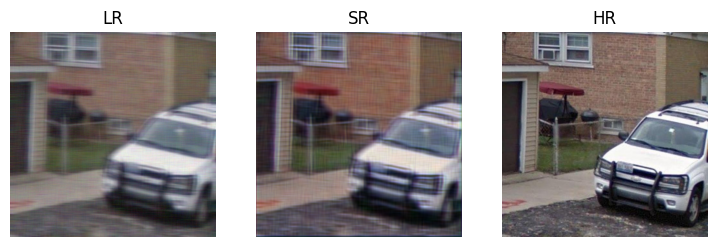

In [27]:
%matplotlib inline

image_name = image_names[n]
n+=1
lrimage = read_image(LR_path+image_name)
lrimage = lrimage.to(torch.float)
lrimage = lrimage.to(device)
lrimage/=255
hrimage = read_image(HR_path+image_name)
hrimage = hrimage.to(torch.float)
hrimage = hrimage.to(device)
hrimage/=255
# lrimage.shape

lrimages = lrimage.unsqueeze(0)
# lrimages.shape

srimgs = srm(lrimages)
srimgs = (srimgs - torch.min(srimgs)) / (torch.max(srimgs)-torch.min(srimgs))

fig,axes = plt.subplots(1,3,figsize=(9,27))
axes[0].imshow(lrimages[0].cpu().squeeze().permute(1,2,0))
axes[1].imshow(srimgs[0].detach().cpu().squeeze().permute(1,2,0))
axes[2].imshow(hrimage.permute(1,2,0))
axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")
axes[0].set_title("LR")
axes[1].set_title("SR")
axes[2].set_title("HR")
plt.show()

In [13]:
srimg = srimgs[0]
to_pil = transforms.ToPILImage()
srimg_pil = to_pil(srimg)
x = srimg_pil.save(dataset_path+"/test/test.jpg")
x

In [19]:
import torch
import gc
import psutil

# Function to print GPU memory usage
def print_gpu_memory():
    print(f"Allocated GPU memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached GPU memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

# Function to print RAM usage
def print_ram_memory():
    process = psutil.Process()
    print(f"RAM usage: {process.memory_info().rss / 1024**2:.2f} MB")

print("Before allocation:")
print_ram_memory()
print_gpu_memory()

# Create tensors
tensor_cpu = torch.randn(1000, 1000)
tensor_cuda = torch.randn(1000, 1000).cuda()

# Print RAM and GPU memory usage before deletion
print("\nBefore deletion:")
print_ram_memory()
print_gpu_memory()

# Remove tensor from RAM
del tensor_cpu

# Remove tensor from GPU
del tensor_cuda

# Clear CUDA cache
torch.cuda.empty_cache()

# Run garbage collector
gc.collect()

# Print RAM and GPU memory usage after deletion
print("\nAfter deletion:")
print_ram_memory()
print_gpu_memory()

Before allocation:
RAM usage: 6157.51 MB
Allocated GPU memory: 0.00 MB
Cached GPU memory: 0.00 MB

Before deletion:
RAM usage: 5452.31 MB
Allocated GPU memory: 3.81 MB
Cached GPU memory: 20.00 MB

After deletion:
RAM usage: 4524.21 MB
Allocated GPU memory: 0.00 MB
Cached GPU memory: 0.00 MB


In [28]:
from tqdm import tqdm

In [29]:
mode = "test"
to_pil = transforms.ToPILImage()

image_names = list(listdir(dataset_path+"/"+mode+"_HR"))
image_list = []
saved = 0
n = len(image_names)

for i in tqdm(range(n)):
    image = read_image(dataset_path+"/"+mode+"_LR/"+image_names[i])
    image = image.to(device)
    image = image.to(torch.float)
    image /= 255
    image_unsqueezed = image.unsqueeze(0)
    sr_image = srm(image_unsqueezed)
    sr_image = sr_image.squeeze()
    sr_image = (sr_image - torch.min(sr_image)) / (torch.max(sr_image)-torch.min(sr_image))
    pil_image = to_pil(sr_image)
    pil_image.save(dataset_path+"/"+mode+"_SR_fullcontent/"+image_names[i])
    saved+=1
    # print(f"{i+1}/{n}")
    del image
    del sr_image
    del pil_image

print("Saved: ",saved," Total: ",n)

100%|██████████| 133/133 [07:03<00:00,  3.18s/it]

Saved:  133  Total:  133
